In [1]:
from blue_conduit_spatial.utilities import load_datasets, load_predictions, select_data
from blue_conduit_spatial.evaluation import generate_hit_rate_curve, generate_hit_rate_curve_by_partition, plot_hit_rate_curve, dig_stats, dig_savings

data_dir = '../data'
load_dir = f'{data_dir}/Processed'
pred_dir = f'{data_dir}/Predictions'
pid_lat_lon_path = f'{load_dir}/pid.gpkg'

# Load data for all hexagons resolutions, train sizes and splits
Xdata, Ydata, pid, train_idx, test_idx, partitions_builder = load_datasets(load_dir)
train_pred_all_bl, test_pred_all_bl = load_predictions(pred_dir, probs_prefix='baseline')
train_pred_all_diff, test_pred_all_diff = load_predictions(pred_dir, probs_prefix='diffusion')

# Filter the data for one selection of hyperparameters (hexagons resolutions, train sizes and splits)
n_hexagons = 47
train_size = 0.1
split = 0

args = {    
    'Xdata': Xdata,
    'Ydata': Ydata,
    'pid': pid,
    'train_idx': train_idx,
    'test_idx': test_idx,
    'train_size': train_size,
    'split': split,
    'return_pid': False,
    'generate_hexagons': False
}

# Data selection arguments
args_bl, args_diff = args.copy(), args.copy()

# Set data selection arguments for Baseline model
args_bl['train_pred_all'] = train_pred_all_bl
args_bl['test_pred_all'] = test_pred_all_bl

# Set data selection arguments for Diffusion model
args_diff['train_pred_all'] = train_pred_all_diff
args_diff['test_pred_all'] = test_pred_all_diff

# Select data per model
data_bl = select_data(**args_bl)
data_diff = select_data(**args_diff)

# Get city map hexagons
hexagons = partitions_builder.Partition(partition_type='hexagon', num_cells_across=n_hexagons)
parcel_gdf = hexagons.parcel_gdf

2021-11-08 22:16.24 [info     ] Generating the partition map of type 'hexagon'


100%|████████████████████████████████████| 1138/1138 [00:00<00:00, 16763.90it/s]

2021-11-08 22:16.27 [info     ] Tesselate() is performing gpd.sjoin() to remove partitions that contain no parcels.
2021-11-08 22:16.27 [info     ] Building the partition-parcel lookup table with add_partition_ID_via_sjoin()



/Users/Javiera/Desktop/Harvard/MS/Classes/Third Term/AC297r/teamBlueConduit/gizmo/gizmo/spatial_partitions/partitions.py:112: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  self.partition_gdf, self.parcel_gdf = partition_utils.tesselate(


2021-11-08 22:16.29 [debug    ] Total parcels after join: 26857
2021-11-08 22:16.29 [info     ] Building the connected graph on the partitions.
2021-11-08 22:16.32 [info     ] New Partition dataframe of type 'hexagon' created, using at least 14.37 MB of memory


In [10]:
# Set `dig_stats` arguments
parcel_gdf = parcel_gdf
index_list = data_bl['test_index']
y_true = data_bl['Ytest']
y_pred = [data_bl['test_pred'], data_diff['test_pred']]
strat_names = ['Baseline', 'Diffusion']
bins = 15

# Get digging statistics
mode = 'digs_number'
dig_stats_df = dig_stats(parcel_gdf, index_list, y_true, y_pred, strat_names=strat_names, bins=bins, mode=mode)
dig_stats_df

Model        Baseline                                    Diffusion            \
Statistics prob_thres digs_lead  hit_rate digs_lead_cum prob_thres digs_lead   
digs_cum                                                                       
1287              0.9      1189  0.923854          1189        0.9      1199   
2573              0.9      1186  0.922240          2375        0.9      1202   
3859              0.9      1190  0.925350          3565        0.8      1201   
5145              0.9      1180  0.917574          4745        0.7      1151   
6431              0.8      1133  0.881026          5878        0.6      1079   
7717              0.3       781  0.607309          6659        0.4       843   
9003              0.0       225  0.174961          6884        0.2       298   
10290             0.0        11  0.008547          6895        0.1       115   
11576             0.0        19  0.014774          6914        0.0        38   
12862             0.0        22  0.017107          6936        0.0        12   
14148             0.0        34  0.026439          6970        0.0        11   
15434             0.0        35  0.027216          7005        0.0        11   
16720             0.0        33  0.025661          7038        0.0        12   
18006             0.0        69  0.053655          7107        0.0        28   
19293             0.0       137  0.106449          7244        0.0        44   

Model                               
Statistics  hit_rate digs_lead_cum  
digs_cum                            
1287        0.931624          1199  
2573        0.934681          2401  
3859        0.933904          3602  
5145        0.895023          4753  
6431        0.839036          5832  
7717        0.655521          6675  
9003        0.231726          6973  
10290       0.089355          7088  
11576       0.029549          7126  
12862       0.009331          7138  
14148       0.008554          7149  
15434       0.008554          7160  
16720       0.009331          7172  
18006       0.021773          7200  
19293       0.034188          7244

In [11]:
dig_stats_df.head()

Model        Baseline                                    Diffusion            \
Statistics prob_thres digs_lead  hit_rate digs_lead_cum prob_thres digs_lead   
digs_cum                                                                       
1287              0.9      1189  0.923854          1189        0.9      1199   
2573              0.9      1186  0.922240          2375        0.9      1202   
3859              0.9      1190  0.925350          3565        0.8      1201   
5145              0.9      1180  0.917574          4745        0.7      1151   
6431              0.8      1133  0.881026          5878        0.6      1079   

Model                               
Statistics  hit_rate digs_lead_cum  
digs_cum                            
1287        0.931624          1199  
2573        0.934681          2401  
3859        0.933904          3602  
5145        0.895023          4753  
6431        0.839036          5832

In [3]:
mode = 'digs_lead_number'
dig_stats_df = dig_stats(parcel_gdf, index_list, y_true, y_pred, strat_names=strat_names, bins=bins, mode=mode)
dig_stats_df = dig_savings(dig_stats_df, 'Baseline', 'Diffusion')
dig_stats_df

Model           Baseline                                                      \
Statistics    prob_thres  hit_rate   digs digs_cum         cost     cost_cum   
digs_lead_cum                                                                  
483                  0.9  0.945205    511      511   $2,499,000   $2,499,000   
966                  0.9  0.904494    534     1045   $2,568,000   $5,067,000   
1449                 0.9  0.916509    527     1572   $2,547,000   $7,614,000   
1932                 0.9  0.913043    529     2101   $2,553,000  $10,167,000   
2415                 0.9  0.928846    520     2621   $2,526,000  $12,693,000   
2898                 0.9  0.937864    515     3136   $2,511,000  $15,204,000   
3381                 0.9  0.914773    528     3664   $2,550,000  $17,754,000   
3863                 0.9  0.918095    525     4189   $2,539,000  $20,293,000   
4346                 0.9  0.913043    529     4718   $2,553,000  $22,846,000   
4829                 0.9  0.921756    524     5242   $2,538,000  $25,384,000   
5312                 0.9  0.911321    530     5772   $2,556,000  $27,940,000   
5795                 0.9  0.881387    548     6320   $2,610,000  $30,550,000   
6278                 0.7  0.734043    658     6978   $2,940,000  $33,490,000   
6761                 0.2  0.444751   1086     8064   $4,224,000  $37,714,000   
7244                 0.0  0.043014  11229    19293  $34,653,000  $72,367,000   

Model          Diffusion                                                      \
Statistics    prob_thres  hit_rate   digs digs_cum         cost     cost_cum   
digs_lead_cum                                                                  
483                  0.9  0.948919    509      509   $2,493,000   $2,493,000   
966                  0.9  0.909605    531     1040   $2,559,000   $5,052,000   
1449                 0.9  0.939689    514     1554   $2,508,000   $7,560,000   
1932                 0.9  0.920000    525     2079   $2,541,000  $10,101,000   
2415                 0.9  0.948919    509     2588   $2,493,000  $12,594,000   
2898                 0.9  0.950787    508     3096   $2,490,000  $15,084,000   
3381                 0.9  0.925287    522     3618   $2,532,000  $17,616,000   
3863                 0.8  0.914611    527     4145   $2,545,000  $20,161,000   
4346                 0.8  0.901119    536     4681   $2,574,000  $22,735,000   
4829                 0.7  0.884615    546     5227   $2,604,000  $25,339,000   
5312                 0.7  0.840000    575     5802   $2,691,000  $28,030,000   
5795                 0.6  0.824232    586     6388   $2,724,000  $30,754,000   
6278                 0.5  0.790507    611     6999   $2,799,000  $33,553,000   
6761                 0.4  0.507886    951     7950   $3,819,000  $37,372,000   
7244                 0.0  0.042581  11343    19293  $34,995,000  $72,367,000   

Model         Savings Diffusion over Baseline  
Statistics                                     
digs_lead_cum                                  
483                                    $6,000  
966                                   $15,000  
1449                                  $54,000  
1932                                  $66,000  
2415                                  $99,000  
2898                                 $120,000  
3381                                 $138,000  
3863                                 $132,000  
4346                                 $111,000  
4829                                  $45,000  
5312                                 $-90,000  
5795                                $-204,000  
6278                                 $-63,000  
6761                                 $342,000  
7244                                       $0

In [9]:
dig_stats_df.head()

Model           Baseline                                                   \
Statistics    prob_thres  hit_rate digs digs_cum        cost     cost_cum   
digs_lead_cum                                                               
483                  0.9  0.945205  511      511  $2,499,000   $2,499,000   
966                  0.9  0.904494  534     1045  $2,568,000   $5,067,000   
1449                 0.9  0.916509  527     1572  $2,547,000   $7,614,000   
1932                 0.9  0.913043  529     2101  $2,553,000  $10,167,000   
2415                 0.9  0.928846  520     2621  $2,526,000  $12,693,000   

Model          Diffusion                                                   \
Statistics    prob_thres  hit_rate digs digs_cum        cost     cost_cum   
digs_lead_cum                                                               
483                  0.9  0.948919  509      509  $2,493,000   $2,493,000   
966                  0.9  0.909605  531     1040  $2,559,000   $5,052,000   
1449                 0.9  0.939689  514     1554  $2,508,000   $7,560,000   
1932                 0.9  0.920000  525     2079  $2,541,000  $10,101,000   
2415                 0.9  0.948919  509     2588  $2,493,000  $12,594,000   

Model         Savings Diffusion over Baseline  
Statistics                                     
digs_lead_cum                                  
483                                    $6,000  
966                                   $15,000  
1449                                  $54,000  
1932                                  $66,000  
2415                                  $99,000

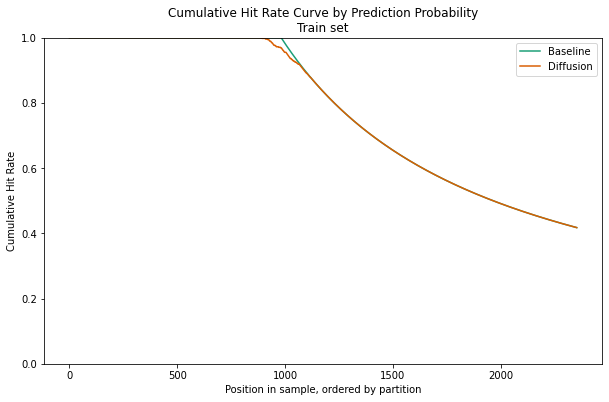

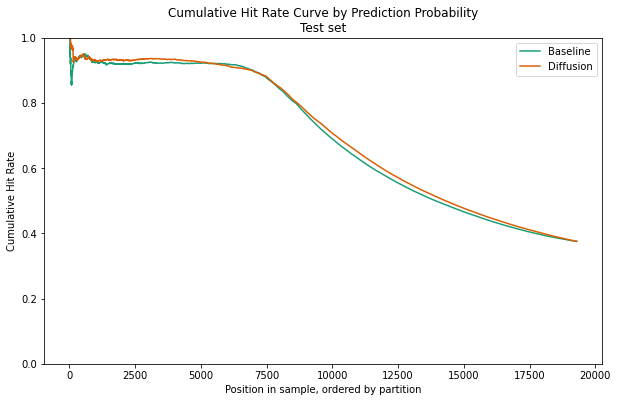

In [6]:
# plot hit rate curves

train_index = data_bl['train_index']
test_index = data_bl['test_index']
y_train = data_bl['Ytrain']
y_test = data_bl['Ytest']

plot_args = {
    'plot_probs': False,
    'labels':['Baseline', 'Diffusion'],
    'max_perf':False,
    'order_by_prob':False,
    'figsize':(10,6),
    'savefig':False,
    'mode':'partition',
    'parcel_df':parcel_gdf,
    'threshold_init':0.9
}

plot_args_train = plot_args.copy()
plot_args_train['y_true'] = y_train
plot_args_train['y_pred'] = [data_bl['train_pred'], data_diff['train_pred']]
plot_args_train['index_list'] = train_index
plot_args_train['title_suffix'] = 'Train set'
plot_hit_rate_curve(**plot_args_train)

plot_args_test = plot_args.copy()
plot_args_test['y_true'] = y_test
plot_args_test['y_pred'] = [data_bl['test_pred'], data_diff['test_pred']]
plot_args_test['index_list'] = test_index
plot_args_test['title_suffix'] = 'Test set'
plot_hit_rate_curve(**plot_args_test)

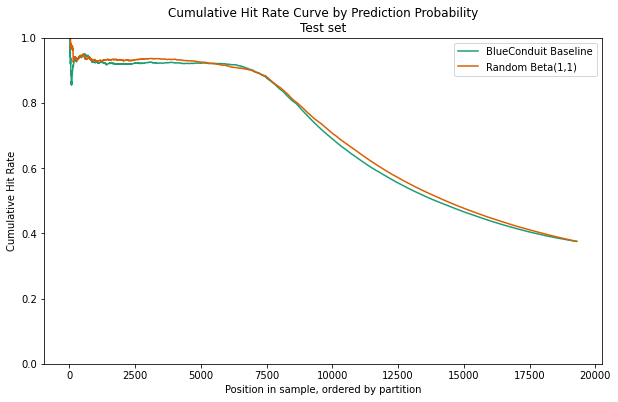

In [7]:
# plot hit rate curves
test_index = data_bl['test_index']
y_test = data_bl['Ytest']

plot_args = {
    'plot_probs': False,
    'labels':['BlueConduit Baseline', 'Random Beta(1,1)'],
    'mode':'all',
    'y_true': y_test,
    'y_pred': [data_bl['test_pred'], data_diff['test_pred']],
    'title_suffix': 'Test set',
    'mode':'partition',
    'parcel_df':parcel_gdf,
    'index_list': test_index,   
    'threshold_init':0.9
}

plot_hit_rate_curve(**plot_args)

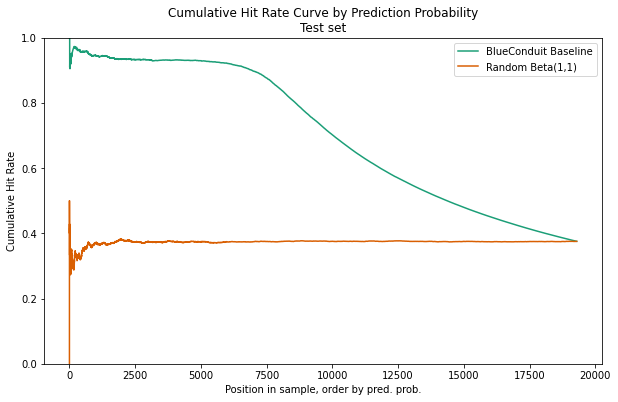

In [8]:
import numpy as np

plot_args = {
    'plot_probs': False,
    'labels':['BlueConduit Baseline', 'Random Beta(1,1)'],
    'mode':'all',
    'y_true': y_test,
    'y_pred': [data_bl['test_pred'], np.random.beta(1, 1, size=len(y_test))],
    'title_suffix': 'Test set'
}

plot_hit_rate_curve(**plot_args)